In [40]:
import sys
sys.path.append('../')

import pandas as pd
import os                                                                                               
from src import data_io
import shelve
from contextlib import closing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cPickle as pickle

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score

from time import time

In [2]:
load = True
if load:
    bidders_d, auctions_d = data_io.load_bidders_auctions()
    
train_ids = [bidder_id for bidder_id, bidder in bidders_d.items() 
             if bidder.true_outcome != None]

train_bidders = [bidders_d[train_id] for train_id in train_ids]



In [3]:
bids_df = data_io.load_bids()

In [4]:
y = np.array([b.true_outcome for b in train_bidders])
k = 4
skf = StratifiedKFold(y, n_folds=k, random_state=0)

In [45]:
snipe_feats = pickle.load((open('../data/snipe_counts.p', 'rb')))
diversity_feats = pd.read_pickle('../data/df_diversity_feats.p').to_dict()['diversity_feat']
peak_feats = pd.read_pickle('../data/df_peak_feats.p').to_dict()['peak_feat']

In [48]:
import features
reload(features)
from features import *

tic = time()

X1 = [snipe_counts[b.bidder_id] for b in train_bidders]
X2 = BidsPerAuct().transform(train_bidders)
# X3 = BidDiversity(bids_df).transform(train_bidders)
X3 = [diversity_feats[b.bidder_id] for b in train_bidders]
X4 = [peak_feats[b.bidder_id] for b in train_bidders]

# X = np.c_[X1, X2, X3]
X = np.c_[X2, X3, X4]

# Visualization?

In [72]:
import bhtsne

# tsne2 = bhtsne.bh_tsne(X, no_dims=2)
# tsne3 = bhtsne.bh_tsne(X, no_dims=3)
X2_all = BidsPerAuct().transform(bidders_d.values())
X3_all = [diversity_feats[b] for b in bidders_d.keys()]
X4_all = [peak_feats[b] for b in bidders_d.keys()]

X_all = np.c_[X2_all, X3_all, X4_all]

tsne2 = bhtsne.bh_tsne(X_all, no_dims=2)
tsne3 = bhtsne.bh_tsne(X_all, no_dims=3)

X_tsne2 = np.array([result for result in tsne2])
X_tsne3 = np.array([result for result in tsne3])

In [93]:
# give y for test subjects
y_tsne = np.array([{0:'b', 1:'r', None:'gray'}[b.true_outcome] for b in bidders_d.values()])

array([False, False, False, ..., False, False, False], dtype=bool)

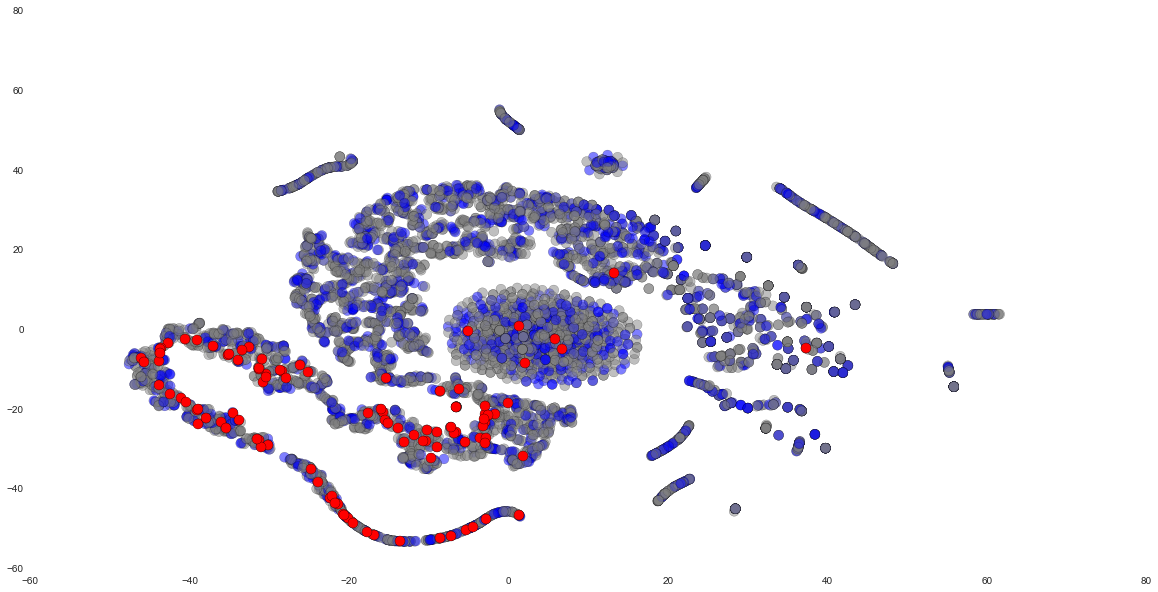

In [94]:
plt.figure(figsize=(20,10))
# ec = {0: 'black', 1: 'r'}
# plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y,
#             lw=1, alpha=1, 
#             cmap='Reds', edgecolor=[ec[y_i] for y_i in y],
#             s=100)

# ec = {0: 'black', 1: 'r'}
# plt.scatter(X_tsne2[np.where(y),0], X_tsne2[np.where(y),1],
#             lw=1, alpha=1, 
#             cmap='Reds', edgecolor=[ec[y_i] for y_i in y],
#             s=100)

plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y_tsne,
            lw=0.3, alpha=0.5,
            s=100)
plt.scatter(X_tsne2[np.where(y_tsne=='r'),0], X_tsne2[np.where(y_tsne=='r'),1],
            c='r', alpha=1, s=100)

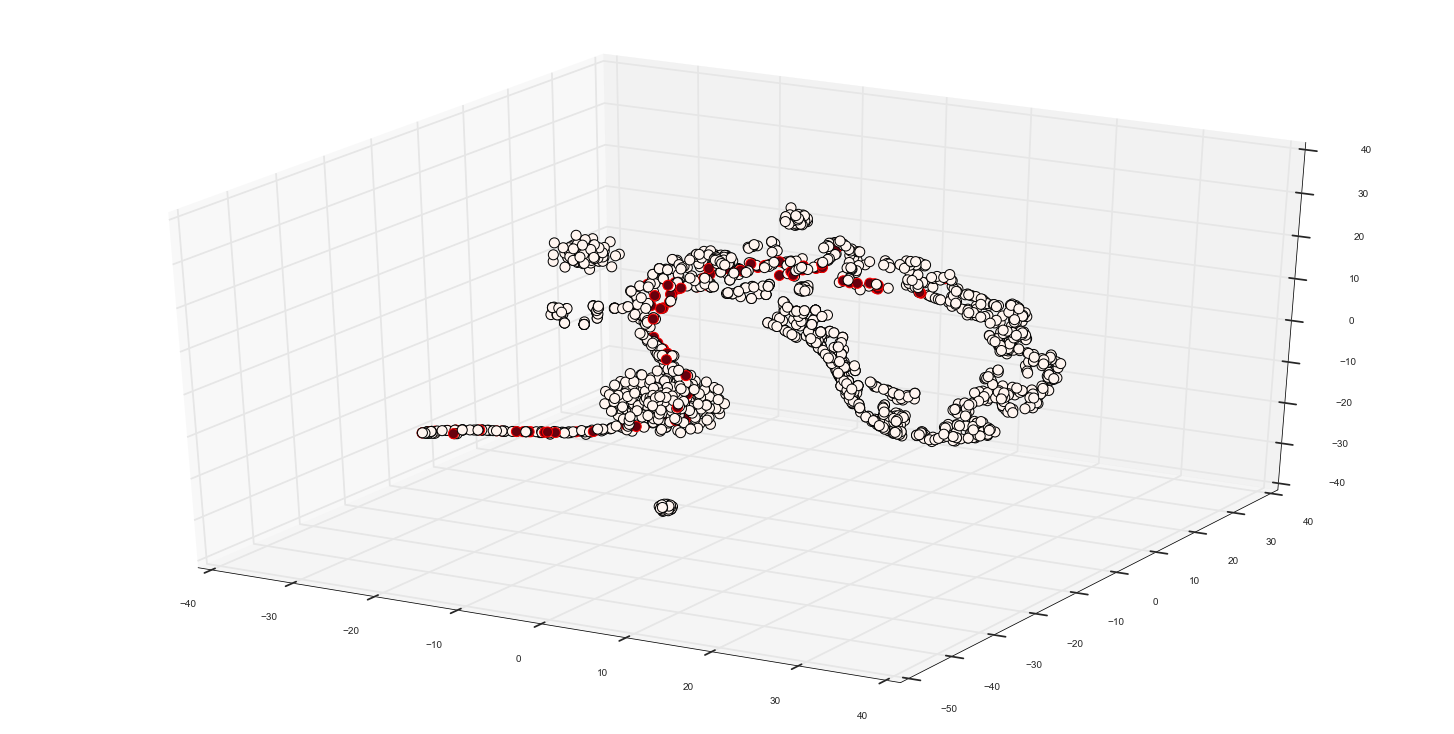

In [322]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
ax.scatter(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c=y,
            lw=1, alpha=1, 
            cmap='Reds', edgecolor=[ec[y_i] for y_i in y],
            s=100)

In [324]:
# Adding tsne reduction to feats
X = np.c_[X, X_tsne3]

# Some sklearn models

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier



# clf = SVC(probability=True)
# clf = AdaBoostClassifier(n_estimators=10, learning_rate=0.2)
# clf = BaggingClassifier(n_estimators=500,
#                         bootstrap_features=True,
#                         max_samples=1.0,
#                         max_features=0.9,
#                         n_jobs=-1)
# clf = ExtraTreesClassifier(n_estimators=200, 
#                            bootstrap=True,
#                            n_jobs=-1)

# clf = AdaBoostClassifier(base_estimator=et, n_estimators=10, learning_rate=0.2)

# clf = KNeighborsClassifier(n_neighbors=100, weights='distance', metric='minkowski')

# clf = GradientBoostingClassifier(n_estimators=1000)

In [133]:
scores = cross_val_score(
    estimator=clf, 
    X=X, y=y, 
    scoring='roc_auc',
    cv=skf, 
    n_jobs=1)

In [134]:
print scores
print scores.mean()
print scores.std()

[ 0.90219665  0.887673    0.8766328   0.90524109]
0.892935885122
0.0115181208418


#Trying XGBoost

In [52]:
import xgboost as xgb

# Parameters for XGB
params = {
    'num_class': 2,
    'silent': 0,    # 0 is verbose
    'nthread': 7,    # max if not set
    
    'bst:eta': 0.5,
    'bst:gamma': 0,
    'bst:max_depth': 1000,
    'bst:min_child_weight': 1,
    'bst:max_delta_step': 0,
    'bst:subsample': 0.9,    # Row (observation) subsample
    'bst:colsample_bytree': 0.2,    # Col (feature) subsample
    
    'objective':'binary:logitraw',
    'eval_metric': 'auc',
    
    'seed': 0,
}


dtrain = xgb.DMatrix(X, label=y)

In [53]:
num_round = 100
scores_xgb = xgb.cv(params, dtrain, num_round, nfold=3,
                    metrics={'auc'}, seed = 0)

[0]	cv-test-auc:0.484349+0.044122	cv-train-auc:0.543685+0.008497
[1]	cv-test-auc:0.507257+0.016065	cv-train-auc:0.609443+0.027693
[2]	cv-test-auc:0.521021+0.032250	cv-train-auc:0.781673+0.028050
[3]	cv-test-auc:0.523152+0.023997	cv-train-auc:0.857155+0.010545
[4]	cv-test-auc:0.521829+0.034766	cv-train-auc:0.888283+0.013257
[5]	cv-test-auc:0.525228+0.006112	cv-train-auc:0.911747+0.008287
[6]	cv-test-auc:0.519812+0.015543	cv-train-auc:0.922109+0.002187
[7]	cv-test-auc:0.516674+0.014464	cv-train-auc:0.926392+0.004413
[8]	cv-test-auc:0.526559+0.004108	cv-train-auc:0.933166+0.001291
[9]	cv-test-auc:0.525517+0.013004	cv-train-auc:0.943159+0.002535
[10]	cv-test-auc:0.536742+0.011237	cv-train-auc:0.946821+0.000868
[11]	cv-test-auc:0.539175+0.017557	cv-train-auc:0.949946+0.001468
[12]	cv-test-auc:0.541324+0.028154	cv-train-auc:0.956162+0.004056
[13]	cv-test-auc:0.542907+0.029029	cv-train-auc:0.958867+0.004675
[14]	cv-test-auc:0.537111+0.032743	cv-train-auc:0.964560+0.003631
[15]	cv-test-auc:0.5

#Testing Keras

In [35]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adadelta
from keras.regularizers import l2

y_enc = np_utils.to_categorical(y)


Using gpu device 0: GeForce GTX 580


In [36]:


def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dropout(0.1))
    model.add(Dense(input_dim, 512, init='he_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, 512, init='he_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, 512, init='he_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512, output_dim, init='he_uniform'))
    model.add(Activation('softmax'))

    adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

In [37]:
scores_keras = []
for ii, (train, valid) in enumerate(skf):
    print('---'*20)
    print('Fold', ii)
    print('---'*20)
    X_train = X[train]
    X_valid = X[valid]
    Y_train = y_enc[train]
    Y_valid = y_enc[valid]
    y_valid = y[valid]
    
    print("Building model...")
    dims = X.shape[1]
    nb_classes = y_enc.shape[1]
    model = build_model(dims, nb_classes)

    print("Training model...")

    model.fit(X_train, Y_train, nb_epoch=100, batch_size=128, 
              validation_data=(X_valid, Y_valid), verbose=0)
    valid_preds = model.predict_proba(X_valid, verbose=0)
    valid_preds = valid_preds[:, 1]
    roc = roc_auc_score(y_valid, valid_preds)
    print("ROC:", roc)
    scores_keras.append(roc)


------------------------------------------------------------
('Fold', 0)
------------------------------------------------------------
Building model...
Training model...
('ROC:', 0.88606372706791126)
------------------------------------------------------------
('Fold', 1)
------------------------------------------------------------
Building model...
Training model...
('ROC:', 0.83754425490827167)
------------------------------------------------------------
('Fold', 2)
------------------------------------------------------------
Building model...
Training model...
('ROC:', 0.82841477181099821)
------------------------------------------------------------
('Fold', 3)
------------------------------------------------------------
Building model...
Training model...
('ROC:', 0.87538784067085962)


In [38]:
np.mean(scores_keras)

0.85685264861451016

In [ ]:
# valid_preds
valid_preds[np.where(y_valid)]

# Prediction

## Ok, train first

In [135]:
clf_et = ExtraTreesClassifier(n_estimators=200, 
                           bootstrap=True,
                           n_jobs=-1)
clf_adab = AdaBoostClassifier(n_estimators=10, learning_rate=0.2)
clf_bc = BaggingClassifier(n_estimators=500,
                        bootstrap_features=True,
                        max_samples=1.0,
                        max_features=0.9,
                        n_jobs=-1)

clf_et.fit(X, y)
clf_adab.fit(X, y)
clf_bc.fit(X, y)


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=True, max_features=0.9, max_samples=1.0,
         n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0)

## Setup test obs

In [100]:
sub = pd.read_csv('../data/sampleSubmission.csv')
test_bidders = [bidders_d[test_id] for test_id in sub['bidder_id']]
len(test_bidders)

4700

In [102]:
X1_test = [snipe_counts[b.bidder_id] for b in test_bidders_id]
X2_test = BidsPerAuct().transform(test_bidders)
X3_test = [diversity_feats[b.bidder_id] for b in test_bidders_id]
X4_test = [peak_feats[b.bidder_id] for b in test_bidders_id]

X_test = np.c_[X2_test, X3_test, X4_test]

In [140]:
y_pred_et = clf_et.predict_proba(X_test)[:, 1]
y_pred_adab = clf_adab.predict_proba(X_test)[:, 1]
y_pred_bc = clf_bc.predict_proba(X_test)[:, 1]

y_pred_avg = np.array([y_pred_et, y_pred_adab, y_pred_bc]).mean(axis=0)

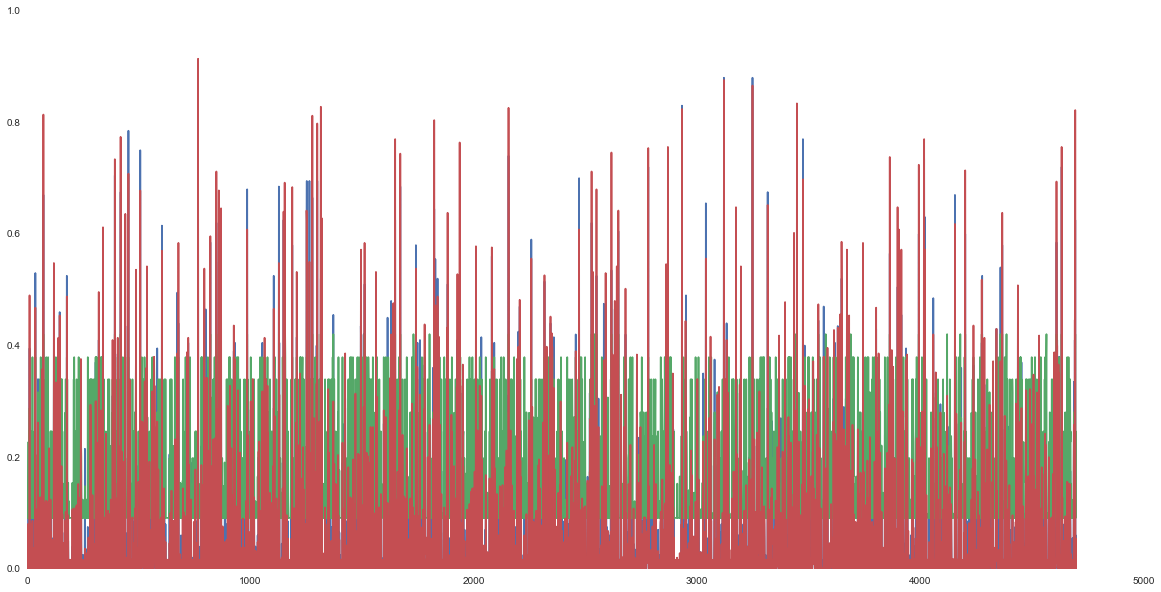

In [139]:
plt.figure(figsize=(20,10))
plt.plot(np.array([y_pred_et, y_pred_adab, y_pred_bc]).T)

In [148]:
y_pred_avg.sum()

400.09619033291784

In [150]:
sub['prediction'] = y_pred_avg

In [154]:
sub.to_csv('../submissions/et-adab-bc_avg.csv', index=False)